In [1]:
import numpy as np
import math
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cv2


In [2]:
def get_nearest_index(olat, olon, lats, lons):
    diff = (lats - olat)**2. + (lons - olon)**2.
    iy, ix = np.unravel_index(np.argmin(diff), diff.shape)
    return iy, ix

In [3]:
fname_dnsc = f"dnsc_static_lcc.nc"
fname_rdps = f"rdaps_kim_3km_static.nc"

dnsc_ds = Dataset(fname_dnsc)

idx = dnsc_ds['i_Index'][:] #- 1   # for fortran (471.279 ~ 701.019) 인덱스의 y값
jdx = dnsc_ds['j_Index'][:] #- 1   # for fortran (227.9~ 452.699 ) 인덱스의 x

dlat = dnsc_ds['LAT'][:] 
dlon = dnsc_ds['LON'][:]

rdps_ds = Dataset(fname_rdps)

rlat = rdps_ds['LAT'][:]
rlon = rdps_ds['XLONG'][:]

In [4]:
# Target
ii, jj = 10, 10 #함수에서 주게 설정하면 됨!, dnsc 상에서의 인덱스!

targ_lat = dlat[jj,ii]
targ_lon = dlon[jj,ii]

iy, ix = get_nearest_index(targ_lat, targ_lon, rlat, rlon)

print(f"nearest index : ({iy}, {ix})")

print(f"nearest index's lat , lon : ({rlat[iy,ix]},{rlon[iy,ix]})")

print(f"target latlon : ({targ_lat}, {targ_lon})")



print(f"target index  : ({jdx[jj,ii]}, {idx[jj,ii]})") #위도:아래위,경도: 좌우 
# target index를 infer하는 방법을 찾아내야 한다. 즉 이게 정답임!




nearest index : (228, 471)
nearest index's lat , lon : (32.73050308227539,124.28118896484375)
target latlon : (32.72452163696289, 124.28506469726562)
target index  : (228.27850341796875, 471.61663818359375)


# 1. 일단 코너점을 찾는 것 까지는 동일  
**(코너점의 latlon은 대각선의 교점, 인덱스는 그냥 ∓0.5 )**  
코너점과 타겟 점 찍기. (코너점들로부터 IDW 적용하는 거라 그 이전 과정까지는 생략 - idx_infer쪽 코드 참고하기.)

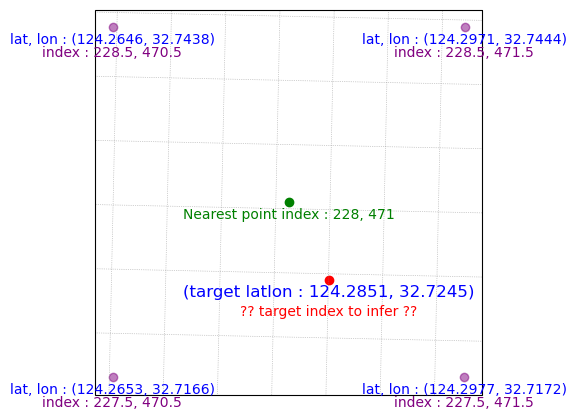

In [5]:

#-- Plot option
fig = plt.figure(figsize=(5, 5))

proj= ccrs.LambertConformal(standard_parallels=(30,60),
                            central_latitude=38.,
                            central_longitude=126.)

cp  = ccrs.PlateCarree() # 직각 좌표 시스템
ax  = fig.add_subplot(1,1,1, projection=proj) #LCC


#-- plot target

ax.scatter(targ_lon, targ_lat, c='red',transform=cp)
ax.text(targ_lon, targ_lat - 0.001, f'(target latlon : {targ_lon:.4f}, {targ_lat:.4f})', fontsize=12, color='blue', transform=cp, ha='center', va='center')
ax.text(targ_lon, targ_lat - 0.0025, f'?? target index to infer ??', fontsize=10, color='red', transform=cp, ha='center', va='center')


#-- plot corners

point_save = [] # corner points saved list 
index_save = [] # corner points' index saved list

for j in range(iy-1, iy+1):  # iy-1부터 iy까지
    for i in range(ix-1, ix+1):  # ix-1부터 ix까지
        
        # rdps latlon 좌표계 상의 사분면 네개에서, 각 4 점의 대각선 점의 중점을 계산 -> 코너점의 (lat, lon)
        diagonal_x = (rlon[j, i] + rlon[j+1, i+1]) / 2
        diagonal_y = (rlat[j, i] + rlat[j+1, i+1]) / 2
        
        point_save.append((diagonal_x, diagonal_y))
        index_save.append((j+0.5,i+0.5))
        
        ax.scatter(diagonal_x, diagonal_y, c='purple', transform=cp, alpha=0.5)
        ax.text(diagonal_x, diagonal_y - 0.001, f'lat, lon : ({diagonal_x:.4f}, {diagonal_y:.4f})', fontsize=10, color='blue', transform=cp, ha='center', va='center')
        ax.text(diagonal_x, diagonal_y - 0.002, f'index : {j+0.5}, {i+0.5}', fontsize=10, color='purple', transform=cp, ha='center', va='center')



# gridlines
ax.gridlines(crs=cp, linestyle=':', linewidth=0.5, color='gray', alpha=0.7)


# 최근점
ax.scatter(rlon[iy,ix], rlat[iy,ix], c='green', transform=cp)
ax.text(rlon[iy,ix], rlat[iy,ix] - 0.001, f'Nearest point index : {iy}, {ix}', fontsize=10, color='green', transform=cp, ha='center', va='center')



plt.show()


# 2. latlon평면상에서 거리 각 코너점과 target점의 거리  
target : (targ_lon, targ_lat)  

각 코너점  : point_save위치에 저장  

코너 1부터 00 10 01 11 순서


코너 1: (rlon[iy-1 , ix-1] + rlon[iy, ix]) / 2 , 
        (rlat[iy-1 , ix-1] + rlat[iy, ix]) / 2


코너 2: (rlon[iy-1 , ix] + rlon[iy, ix+1]) / 2 , 
        (rlat[iy-1 , ix] + rlat[iy, ix+1]) / 2

        
코너 3: (rlon[iy , ix-1] + rlon[iy+1, ix]) / 2 , 
        (rlat[iy , ix-1] + rlat[iy+1, ix]) / 2

        
코너 4: (rlon[iy , ix] + rlon[iy+1, ix+1]) / 2 , 
        (rlat[iy , ix] + rlat[iy+1, ix+1]) / 2



In [6]:
target_pt = (targ_lon, targ_lat)

cor_pt_1 = ( (rlon[iy-1 , ix-1] + rlon[iy, ix]) / 2 , 
        (rlat[iy-1 , ix-1] + rlat[iy, ix]) / 2)

cor_pt_2 = ((rlon[iy-1 , ix] + rlon[iy, ix+1]) / 2 , 
        (rlat[iy-1 , ix] + rlat[iy, ix+1]) / 2)

cor_pt_3 = ((rlon[iy , ix-1] + rlon[iy+1, ix]) / 2 , 
        (rlat[iy , ix-1] + rlat[iy+1, ix]) / 2)

cor_pt_4 = ((rlon[iy , ix] + rlon[iy+1, ix+1]) / 2 , 
        (rlat[iy , ix] + rlat[iy+1, ix+1]) / 2)

타겟 점과 코너 점들과의 거리 계산 :  LCC 투영법 내에서의 거리보정 필요. (WGS 84)

---
필요한 파라미터들  

**Reference Latitude (참조 위도): 투영 중심의 위도**  
**Reference Longitude (참조 경도): 투영 중심의 경도**  
**투영중심** 

 -  "표준 위도를 설정하는 것은 어떤 지역을 투영하거나 어떤 용도로 지도를 사용할지에 따라 달라집니다. 예를 들어, 지도가 특정 위도 범위 내에서 높은 정확도를 유지해야 하는 경우 해당 위도 범위의 표준 위도를 선택할 수 있습니다."

**한반도 위도 범위 사용하자**

False Easting (가로 거리 보정): 일반적으로 0으로 설정
False Northing (세로 거리 보정): 일반적으로 0으로 설정  

In [7]:
def lcc_distance(lon_a, lat_a, lon_b, lat_b, ref_lon, ref_lat, std_parallels):
    
    a = 6378137.0# WGS 84 지구 반경        
    e = 0.0818191910435 #편심률
    
    # Convert degrees to radians
    lat_a = math.radians(lat_a)
    lon_a = math.radians(lon_a)
    lat_b = math.radians(lat_b)
    lon_b = math.radians(lon_b)
    
    ref_lat = math.radians(ref_lat)
    
    
    m_a = math.cos(lat_a) / math.sqrt(1 - (e ** 2) * (math.sin(lat_a) ** 2))
    m_b = math.cos(lat_b) / math.sqrt(1 - (e ** 2) * (math.sin(lat_b) ** 2))
    

    n = (math.log(m_a) - math.log(m_b)) / (math.log(math.tan(math.pi / 4 + lat_b / 2)) - math.log(math.tan(math.pi / 4 + lat_a / 2)))
    F = m_a / (n * (math.tan(math.pi / 4 + lat_a / 2) ** n))
    rho_0 = a * F * (math.tan(math.pi / 4 + ref_lat / 2) ** n)
    rho_a = a * F * (math.tan(math.pi / 4 + lat_a / 2) ** n)
    rho_b = a * F * (math.tan(math.pi / 4 + lat_b / 2) ** n)
    
    x_a = rho_a * math.sin(n * (lon_a - ref_lon))
    y_a = rho_0 - rho_a * math.cos(n * (lon_a - ref_lon))
    x_b = rho_b * math.sin(n * (lon_b - ref_lon))
    y_b = rho_0 - rho_b * math.cos(n * (lon_b - ref_lon))
    
    # 두 점의 거리 계산
    distance = math.sqrt((x_b - x_a) ** 2 + (y_b - y_a) ** 2)
    
    return distance #lcc_distance 계산 함수!


In [8]:
'''
일반적으로 그 지점에서 정확도가 상승해야 하는 경우 그 지점을 넣는 것 같다. 
그래서 타겟점의 위경도로 하기로 결정함.
'''

ref_lon = targ_lon  # 참조 경도
ref_lat = targ_lat  # 참조 위도

std_parallels = [33.0, 43.0]  # 표준 위도 : 한반도 위도 범위로 함

distance_save = []
for i in range(len(point_save)):#len(point_save) = 4 
    distance = lcc_distance(targ_lon, targ_lat, point_save[i][0], point_save[i][1], ref_lon, ref_lat, std_parallels)
    distance_save.append(distance)
    print(f"The distance between target and corner{i} is {distance} meters.")


The distance between target and corner0 is 2052.0666575818996 meters.
The distance between target and corner1 is 1443.2621877987897 meters.
The distance between target and corner2 is 2882.719082030091 meters.
The distance between target and corner3 is 2487.1691575559607 meters.


In [9]:
point_save 

[(124.26531982421875, 32.71656799316406),
 (124.2977294921875, 32.71715545654297),
 (124.26461791992188, 32.743839263916016),
 (124.29705810546875, 32.74442672729492)]

![](order_always.png)  

가중치 함수는 여러가지 방법이 있다고 하는데 기본적으로는  
![](weight_simple.png)  

여기서 p는 주로 1 이상의 양수로, 이 값이 작으면 가파르게, 크면 부드럽게 보간이 된다고 한다. 1~2 사이값으로들 많이 하는듯???  
일단 테스트는 p = 1.5 로 해 보기로 한다.

In [10]:

# 역거리 가중법을 사용하여 타겟의 인덱스를 찾는 함수
def find_target_index(target_pt, distance_save, index_save, p=1.5):
    weighted_sum_lon = 0.0
    weighted_sum_lat = 0.0
    sum_of_weights = 0.0
    
    for i in range(len(distance_save)):
        if distance_save[i] == 0:
            return index_save[i]  # 거리가 0이면 해당 코너 점의 인덱스를 반환
        weight = 1.0 / (distance_save[i] ** p)  # 거리에 반비례하는 가중치 계산
        weighted_sum_lon += (index_save[i][0] * weight)
        weighted_sum_lat += (index_save[i][1] * weight)
        sum_of_weights += weight
    
    if sum_of_weights == 0:
        return None  # 0으로 나누는 경우 None을 반환하거나 다른 처리를 수행할 수 있다
    
    estimated_index = (weighted_sum_lon / sum_of_weights, weighted_sum_lat / sum_of_weights)
    return estimated_index

# 타겟 지점의 (lontitude, latitude)
target_pt = (targ_lon, targ_lat)


# 역거리 가중법을 사용하여 타겟의 인덱스 추정
estimated_index = find_target_index(target_pt, distance_save, index_save, p=1.5)

print(f"Estimated target index: {estimated_index}")

Estimated target index: (227.83371732035982, 471.1043426044145)


! 곡률을 도입한 거리로 계산했을 때가 위와 같으니까. 곡률 버리고 걍 계산  
! 거리를 그냥 일반좌표계처럼 구함 ; 거리함수 simple로 재정의해서 시도

In [11]:


def calculate_euclidean_distance(target_pt, corner_points):
    distance_save_euclid = []  # 유클리드 거리 저장 리스트
    for corner_pt in corner_points:
        # 유클리드 거리 계산
        distance = math.sqrt((corner_pt[0] - target_pt[0]) ** 2 + (corner_pt[1] - target_pt[1]) ** 2) #걍 유클리디언 거리 식임 (nearest point 구하는 함수에서도 썼음)
        distance_save_euclid.append(distance)
    return distance_save_euclid


# 타겟 지점의 (longitude, latitude)
target_pt = (targ_lon, targ_lat)
# 유클리드 거리를 계산하여 리스트에 저장
distance_save_uclid = calculate_euclidean_distance(target_pt, point_save)

# 결과 출력
print("Euclidean Distances:")
for i, distance in enumerate(distance_save_uclid):
    print(f"Distance between target and corner {i + 1}: {distance} meters")

Euclidean Distances:
Distance between target and corner 1: 0.02128662634885688 meters
Distance between target and corner 2: 0.01465119941820434 meters
Distance between target and corner 3: 0.028129013755284593 meters
Distance between target and corner 4: 0.023239071871593967 meters


In [12]:


# 역거리 가중법을 사용하여 타겟의 인덱스 추정 2 (거리를 유클리디언으로)
estimated_index_2 = find_target_index(target_pt, distance_save_uclid, index_save, p=1.5)
print(f"Estimated target index: {estimated_index_2}")


Estimated target index: (227.8581164481626, 471.1131080913672)



# corner points를 직사각형 점이라고 가정 한 후 그냥 bilinear interpolation

In [13]:
print(index_save)
print(point_save)
print('===================================================')
print(target_pt) #tar_lon, tar_lat

[(227.5, 470.5), (227.5, 471.5), (228.5, 470.5), (228.5, 471.5)]
[(124.26531982421875, 32.71656799316406), (124.2977294921875, 32.71715545654297), (124.26461791992188, 32.743839263916016), (124.29705810546875, 32.74442672729492)]
(124.285065, 32.72452)


In [14]:
# 주어진 (lon, lat) 좌표
lon = 124.285065
lat = 32.72452

# 네 개의 인접한 점과 대응하는 (lon, lat) 좌표
lon_lat_points = np.array([(124.26531982421875, 32.71656799316406),
                           (124.2977294921875, 32.71715545654297),
                           (124.26461791992188, 32.743839263916016),
                           (124.29705810546875, 32.74442672729492)])

# 네 개의 인덱스 좌표
index_points = np.array([(227.5, 470.5),
                         (227.5, 471.5),
                         (228.5, 470.5),
                         (228.5, 471.5)])

# 2차원 선형 보간 계산
def linear_interpolation(x, y, x1, y1, x2, y2, q11, q12, q21, q22):
    return (q11 * (x2 - x) * (y2 - y) + q21 * (x - x1) * (y2 - y) + q12 * (x2 - x) * (y - y1) + q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1))

# 선형 보간을 사용하여 (lon, lat) 좌표에서 인덱스 계산
index_lon = linear_interpolation(lon, lat, lon_lat_points[0, 0], lon_lat_points[0, 1], lon_lat_points[1, 0], lon_lat_points[1, 1], index_points[0, 0], index_points[1, 0], index_points[2, 0], index_points[3, 0])
index_lat = linear_interpolation(lon, lat, lon_lat_points[0, 0], lon_lat_points[0, 1], lon_lat_points[1, 0], lon_lat_points[1, 1], index_points[0, 1], index_points[1, 1], index_points[2, 1], index_points[3, 1])

print("선형 보간을 사용한 인덱스 (lon, lat):", (index_lon, index_lat))


선형 보간을 사용한 인덱스 (lon, lat): (228.10923721280628, 484.0361745454522)


# 발표자료용 플로팅

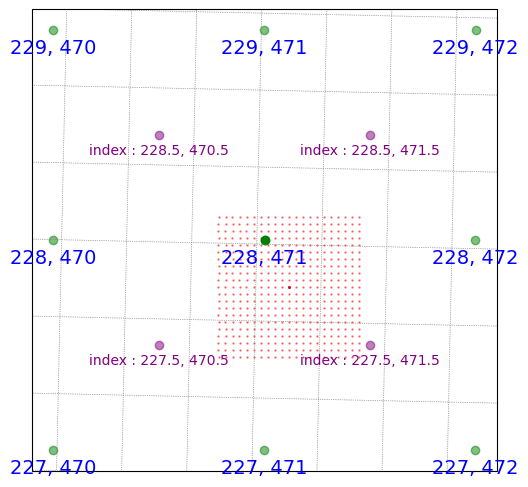

In [15]:

fig = plt.figure(figsize=(6, 6))
proj= ccrs.LambertConformal(standard_parallels=(30,60),
                            central_latitude=38.,
                            central_longitude=126.)
cp  = ccrs.PlateCarree() # 직각 좌표 시스템
ax  = fig.add_subplot(1,1,1, projection=proj)


#dnsc
pad = 10
for i in range(ii-pad, ii+pad+1):
    for j in range(jj-pad, jj+pad+1):
        ax.scatter(dlon[j,i], dlat[j,i], c='red', s=0.5, transform=cp, alpha=0.5)
        
ax.scatter(targ_lon, targ_lat, c='blue', s=0.8, transform=cp)


#r댑스
for j in range(iy-1,iy+2): # 실제로iy-1, iy, iy+1
    for i in range(ix-1,ix+2):
        
        ax.scatter(rlon[j,i], rlat[j,i], c='green', transform=cp, alpha=0.5)
        ax.text(rlon[j, i] , rlat[j, i] - 0.001, f'{j}, {i}', fontsize=14, color='blue', transform=cp, ha='center', va='top') #살짝 빗겨서 출력


#타겟

ax.scatter(targ_lon, targ_lat, c='red',s=0.9,transform=cp)

# 코너점 플로팅

point_save = [] # corner points saved list 
index_save = [] # corner points' index saved list

for j in range(iy-1, iy+1):  # iy-1부터 iy까지
    for i in range(ix-1, ix+1):  # ix-1부터 ix까지
        
        diagonal_x = (rlon[j, i] + rlon[j+1, i+1]) / 2
        diagonal_y = (rlat[j, i] + rlat[j+1, i+1]) / 2
        
        point_save.append((diagonal_x, diagonal_y))
        index_save.append((j+0.5,i+0.5))
        
        ax.scatter(diagonal_x, diagonal_y, c='purple', transform=cp, alpha=0.5)
        ax.text(diagonal_x, diagonal_y - 0.002, f'index : {j+0.5}, {i+0.5}', fontsize=10, color='purple', transform=cp, ha='center', va='center')



ax.scatter(rlon[iy,ix], rlat[iy,ix], c='green', transform=cp)# 최근점
ax.gridlines(crs=cp, linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

plt.show()